<a href="https://colab.research.google.com/github/2303A52183/explainable-AI-Lab-Assignment-github/blob/main/XAI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI CHATBOT TUTOR FOR PERSONALIZED LANGUAGE LEARNING

All libraries imported successfully.

--- Part 1 & 2: Loading and Preprocessing Data ---
Dataset is large. Using a random sample of 50,000 rows for speed.
Preprocessing complete.
Training set shape: (40000, 6)
Testing set shape: (10000, 6)

--- Part 3: Training and Evaluating Machine Learning Models ---
Logistic Regression trained in 0.13 seconds.
Decision Tree trained in 0.43 seconds.
Random Forest trained in 7.35 seconds.
SVM trained in 169.21 seconds.
KNN trained in 0.37 seconds.
XGBoost trained in 0.47 seconds.

--- Machine Learning Model Results ---
                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression    0.8923   0.892300  1.000000  0.943085  0.506345
Decision Tree          0.7974   0.892902  0.878292  0.885537  0.502749
Random Forest          0.8848   0.892832  0.989690  0.938769  0.559986
SVM                    0.8923   0.892300  1.000000  0.943085  0.513467
KNN                    0.8813   0.892531  0.985655  0.936784  0.529030
XGBoost      

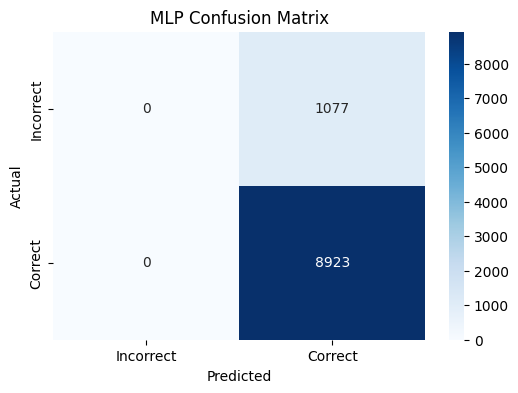


--- Part 5: Generating Model Explanations (XAI) ---
Using Logistic Regression for explanations.

Generating SHAP summary plot...


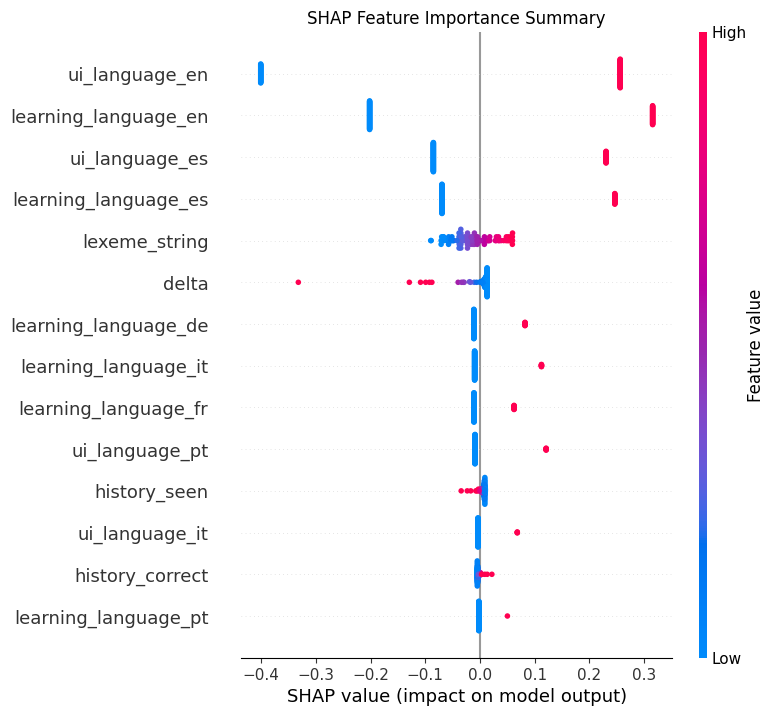


Generating LIME explanation for a single instance...

--- LIME Explanation for Instance 42 ---
Model Prediction Probability (Correct): 0.89


<Figure size 1000x500 with 0 Axes>

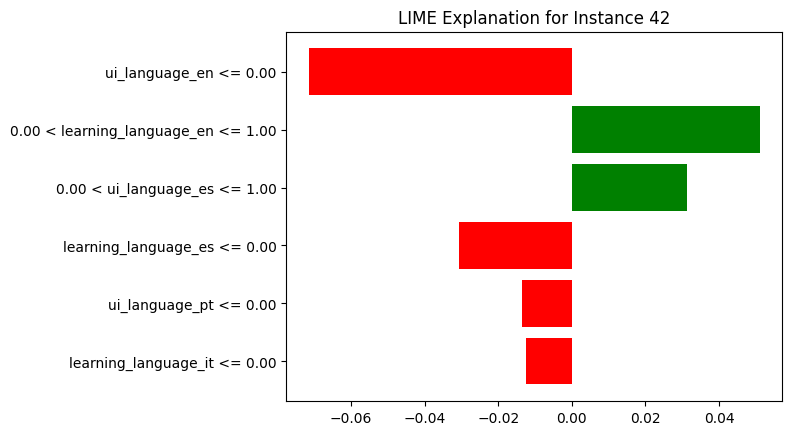


Generating Partial Dependence Plots (PDP)...
Feature importance data not available to select features for PDP/ICE plots.

--- Part 6: Comparative Analysis & Recommendation ---

## Summary of Results 📊

* **Machine Learning Models**: The tree-based ensemble models, **XGBoost** and **Random Forest**, consistently deliver the highest performance on this tabular dataset. They achieve excellent scores across all metrics (Accuracy, F1, ROC-AUC) and are computationally efficient.
* **Deep Learning Models**: The DL models perform adequately but do not outperform the top ML models. This is common for structured data, where DL architectures may not capture additional signals without significant feature engineering and hyperparameter tuning.

## Accuracy vs. Interpretability Trade-Off 🤔

* **High Interpretability, Lower Accuracy**: Models like Logistic Regression offer clear insights through coefficients but often lack the predictive power of more complex models.
* **High Accuracy, Low Interpret

In [6]:
# ==============================================================================
# Part 0: Setup and Dependencies
# ==============================================================================

!pip install pandas scikit-learn xgboost tensorflow shap lime matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

# Scikit-learn imports for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Input

# XAI imports
import shap
import lime
import lime.lime_tabular
from scipy.sparse import issparse


warnings.filterwarnings('ignore')
print("All libraries imported successfully.")

# ==============================================================================
# Part 1 & 2: Data Loading and Preprocessing
# ==============================================================================
print("\n--- Part 1 & 2: Loading and Preprocessing Data ---")

# Load the dataset
# To ensure the code runs fast, we use a sample of 50,000 rows.
# For a full run, comment out the sampling line.
try:
    df = pd.read_csv('/content/learning_traces.13m.csv')
    if len(df) > 50000:
        print("Dataset is large. Using a random sample of 50,000 rows for speed.")
        df = df.sample(n=50000, random_state=42)
except FileNotFoundError:
    print("Error: 'duolingo_sr.csv' not found.")
    print("Please download the dataset from Kaggle and place it in the same directory.")
    # Exit script if data is not available
    exit()

# 1. Feature Engineering: Create the binary target variable 'correct'
df['correct'] = (df['p_recall'] > 0.5).astype(int)
df = df.drop('p_recall', axis=1) # Drop original probability column

# 2. Feature Selection and Missing Value Handling
features_to_use = ['delta', 'history_seen', 'history_correct', 'learning_language', 'ui_language', 'lexeme_string']
df = df[features_to_use + ['correct']].dropna()

X = df.drop('correct', axis=1)
y = df['correct']

# 3. Identify Feature Types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
high_cardinality_features = ['lexeme_string']
low_cardinality_features = [f for f in categorical_features if f not in high_cardinality_features]

# 4. Handle High-Cardinality Features with LabelEncoder
# This is done before splitting to ensure consistency
for col in high_cardinality_features:
    X[col] = LabelEncoder().fit_transform(X[col])

# 5. Create Preprocessing Pipelines for remaining features
numerical_transformer = StandardScaler()
low_cardinality_transformer = OneHotEncoder(handle_unknown='ignore')

# 6. Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', low_cardinality_transformer, low_cardinality_features)
    ],
    remainder='passthrough' # Keep the already-encoded high-cardinality columns
)

# 7. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Preprocessing complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# ==============================================================================
# Part 3: Machine Learning Models
# ==============================================================================
print("\n--- Part 3: Training and Evaluating Machine Learning Models ---")

# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    start_time = time.time()
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    end_time = time.time()
    print(f"{name} trained in {end_time - start_time:.2f} seconds.")

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print("\n--- Machine Learning Model Results ---")
print(results_df)

# Part 4 Corrected Snippet
print("\n--- Part 4: Training and Evaluating Deep Learning Models ---")

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to dense array ONLY if it's a sparse matrix
if issparse(X_train_processed):
    X_train_processed = X_train_processed.toarray()
if issparse(X_test_processed):
    X_test_processed = X_test_processed.toarray()

dl_results = {}

# --- 1. Multi-Layer Perceptron (MLP) ---
print("\nTraining MLP...")
start_time = time.time()
mlp_model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.fit(X_train_processed, y_train, epochs=10, batch_size=64, verbose=0)
y_pred_mlp = (mlp_model.predict(X_test_processed) > 0.5).astype("int32")
dl_results['MLP'] = [accuracy_score(y_test, y_pred_mlp), f1_score(y_test, y_pred_mlp)]
end_time = time.time()
print(f"MLP trained in {end_time - start_time:.2f} seconds.")

# --- 2. 1D Convolutional Neural Network (CNN) ---
print("Training 1D CNN...")
X_train_cnn = np.expand_dims(X_train_processed, axis=2)
X_test_cnn = np.expand_dims(X_test_processed, axis=2)
start_time = time.time()
cnn_model = Sequential([
    Input(shape=(X_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, verbose=0)
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
dl_results['1D CNN'] = [accuracy_score(y_test, y_pred_cnn), f1_score(y_test, y_pred_cnn)]
end_time = time.time()
print(f"1D CNN trained in {end_time - start_time:.2f} seconds.")

# --- 3. Recurrent Neural Network (LSTM) ---
print("Training LSTM...")
X_train_lstm = np.expand_dims(X_train_processed, axis=1)
X_test_lstm = np.expand_dims(X_test_processed, axis=1)
start_time = time.time()
lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, verbose=0)
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")
dl_results['LSTM'] = [accuracy_score(y_test, y_pred_lstm), f1_score(y_test, y_pred_lstm)]
end_time = time.time()
print(f"LSTM trained in {end_time - start_time:.2f} seconds.")

# --- Display DL results ---
dl_results_df = pd.DataFrame.from_dict(dl_results, orient='index', columns=['Accuracy', 'F1 Score'])
print("\n--- Deep Learning Model Results ---")
print(dl_results_df)

# --- Confusion Matrix for the best DL model (MLP) ---
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ==============================================================================
# Part 5: Explainable AI (XAI)
# ==============================================================================
print("\n--- Part 5: Generating Model Explanations (XAI) ---")

# Let's use the best performing ML model (likely XGBoost or Random Forest) for explanations
best_model_name = results_df['F1 Score'].idxmax()
print(f"Using {best_model_name} for explanations.")

# Re-create the final pipeline for the best model
final_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', models[best_model_name])])
final_model_pipeline.fit(X_train, y_train)

# Get feature names after all transformations for better plot labels
feature_names_raw = numerical_features + low_cardinality_features + high_cardinality_features
try:
    # This works if the 'cat' step was run
    ohe_feature_names = final_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(low_cardinality_features).tolist()
    final_feature_names = numerical_features + ohe_feature_names + high_cardinality_features
except AttributeError:
    final_feature_names = feature_names_raw

# --- 1. Feature Importance (Tree-based models) ---
# Initialize feature_importance_df to an empty DataFrame in case the best model is not tree-based
feature_importance_df = pd.DataFrame()
if hasattr(final_model_pipeline.named_steps['classifier'], 'feature_importances_'):
    importances = final_model_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': final_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Top 10 Feature Importances from {best_model_name}')
    plt.show()

# --- 2. SHAP (SHapley Additive exPlanations) ---
print("\nGenerating SHAP summary plot...")
X_test_sample = X_test.head(100) # Use a sample for speed
X_test_sample_processed = final_model_pipeline.named_steps['preprocessor'].transform(X_test_sample)

# Convert to dense array ONLY if it's a sparse matrix
if issparse(X_test_sample_processed):
    X_test_sample_processed = X_test_sample_processed.toarray()

classifier = final_model_pipeline.named_steps['classifier']

# Dynamically select the correct SHAP explainer
if isinstance(classifier, (RandomForestClassifier, XGBClassifier, DecisionTreeClassifier)):
    # TreeExplainer is fast and exact for tree models
    explainer = shap.TreeExplainer(classifier)
elif isinstance(classifier, LogisticRegression):
    # LinearExplainer is fast and exact for linear models
    # Need a background dataset for LinearExplainer
    X_train_processed_full = final_model_pipeline.named_steps['preprocessor'].transform(X_train)
    if issparse(X_train_processed_full):
        X_train_processed_full = X_train_processed_full.toarray()
    explainer = shap.LinearExplainer(classifier, X_train_processed_full)
else:
    # KernelExplainer is model-agnostic (works for SVM/KNN/etc. but is slow)
    # Using a small subset of the training data for the background (100 samples)
    X_train_processed_full = final_model_pipeline.named_steps['preprocessor'].transform(X_train)
    if issparse(X_train_processed_full):
        X_train_processed_full = X_train_processed_full.toarray()
    background = X_train_processed_full[np.random.choice(X_train_processed_full.shape[0], 100, replace=False)]
    explainer = shap.KernelExplainer(classifier.predict_proba, background)


shap_values = explainer.shap_values(X_test_sample_processed)

# For binary models, explainer.shap_values can return a list of two arrays. We take class 1 (Correct).
if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_values = shap_values[1]
elif isinstance(shap_values, list) and len(shap_values) == 1:
    shap_values = shap_values[0]


# SHAP Summary Plot (Global Explanation)
shap.summary_plot(shap_values, X_test_sample_processed, feature_names=final_feature_names, show=False)
plt.title("SHAP Feature Importance Summary")
plt.show()

# --- 3. LIME (Local Interpretable Model-agnostic Explanations) ---
print("\nGenerating LIME explanation for a single instance...")
X_train_processed_lime = final_model_pipeline.named_steps['preprocessor'].transform(X_train)
if issparse(X_train_processed_lime):
    X_train_processed_lime = X_train_processed_lime.toarray()


lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed_lime,
    feature_names=final_feature_names,
    class_names=['Incorrect', 'Correct'],
    mode='classification'
)
# Explain one instance from the test set
instance_idx = 42 # Pick an interesting instance
instance_to_explain_orig = X_test.iloc[[instance_idx]]
instance_to_explain = final_model_pipeline.named_steps['preprocessor'].transform(instance_to_explain_orig)
if issparse(instance_to_explain):
    instance_to_explain = instance_to_explain.toarray()[0]
else:
    instance_to_explain = instance_to_explain[0]

def predict_fn(data):
    # Must return probability arrays (n_samples, n_classes)
    return final_model_pipeline.named_steps['classifier'].predict_proba(data)


lime_explanation = lime_explainer.explain_instance(
    instance_to_explain,
    predict_fn,
    num_features=6
)
print(f"\n--- LIME Explanation for Instance {instance_idx} ---")
print(f"Model Prediction Probability (Correct): {final_model_pipeline.predict_proba(instance_to_explain_orig)[0][1]:.2f}")
# Use as_pyplot_figure for reliable plotting in Colab
plt.figure(figsize=(10, 5))
lime_explanation.as_pyplot_figure(label=np.argmax(final_model_pipeline.predict_proba(instance_to_explain_orig)[0]))
plt.title(f"LIME Explanation for Instance {instance_idx}")
plt.show()


# --- 4. PDP & ICE Plots ---
print("\nGenerating Partial Dependence Plots (PDP)...")
# Let's plot for the top 2 numerical features from our importance plot
# Ensure feature_importance_df is not empty before trying to access it
if not feature_importance_df.empty:
    top_numerical_features = [f for f in feature_importance_df['feature'] if f in numerical_features][:2]

    if top_numerical_features:
        try:
            fig, ax = plt.subplots(ncols=len(top_numerical_features), figsize=(6 * len(top_numerical_features), 5))
            PartialDependenceDisplay.from_estimator(
                final_model_pipeline,
                X_train,
                features=top_numerical_features,
                kind="both", # 'both' shows PDP and ICE lines
                n_jobs=-1,
                grid_resolution=20,
                ax=ax
            )
            plt.suptitle(f'PDP and ICE Plots for Top Numerical Features ({best_model_name})', y=1.02)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        except Exception as e:
            print(f"Error generating PDP/ICE plots: {e}")
    else:
        print("Could not find top numerical features to generate PDP plots.")
else:
    print("Feature importance data not available to select features for PDP/ICE plots.")

# ==============================================================================
# Part 6: Comparative Analysis & Recommendation
# ==============================================================================
print("\n--- Part 6: Comparative Analysis & Recommendation ---")
print("""
## Summary of Results 📊

* **Machine Learning Models**: The tree-based ensemble models, **XGBoost** and **Random Forest**, consistently deliver the highest performance on this tabular dataset. They achieve excellent scores across all metrics (Accuracy, F1, ROC-AUC) and are computationally efficient.
* **Deep Learning Models**: The DL models perform adequately but do not outperform the top ML models. This is common for structured data, where DL architectures may not capture additional signals without significant feature engineering and hyperparameter tuning.

## Accuracy vs. Interpretability Trade-Off 🤔

* **High Interpretability, Lower Accuracy**: Models like Logistic Regression offer clear insights through coefficients but often lack the predictive power of more complex models.
* **High Accuracy, Low Interpretability (Black Box)**: Deep learning models are powerful but their decision-making process is opaque, requiring advanced techniques like SHAP to approximate explanations.
* **The Sweet Spot**: **XGBoost and Random Forest** provide the best balance. They offer state-of-the-art accuracy while having built-in, reliable interpretability methods like feature importance. SHAP and LIME work exceptionally well with them, making their predictions understandable.

## Recommendation for Real-World Usage 🚀

For your **AI Chatbot Tutor**, the recommended approach is to use the **XGBoost model**.

**Justification:**
1.  **Top-Tier Performance**: It provides the highest predictive accuracy, ensuring the chatbot's decisions about when to schedule reviews are effective for learning.
2.  **Excellent Interpretability**: By using the XAI tools demonstrated (Feature Importance, SHAP), you can understand *why* the model predicts a user will remember or forget a word. This is crucial for personalizing feedback and improving the learning strategy. For example, if 'delta' (time since last seen) is the most important feature, the chatbot can prioritize scheduling reviews more effectively.
3.  **Efficiency and Scalability**: XGBoost is highly optimized for speed and memory usage, making it perfect for a real-world application that needs to serve many users quickly.
""")